In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
trades = pd.read_csv("../data/trades_log.csv")
ml_trades = pd.read_csv("../data/trades_with_ml_prediction.csv")
market = pd.read_csv("../data/nifty_with_regime_5min.csv")

trades['entry_time'] = pd.to_datetime(trades['entry_time'])
trades['exit_time'] = pd.to_datetime(trades['exit_time'])
market['datetime'] = pd.to_datetime(market['datetime'])

print("All datasets loaded successfully ✅")


All datasets loaded successfully ✅


In [3]:
trades['duration_min'] = (
    (trades['exit_time'] - trades['entry_time']).dt.total_seconds() / 60
)


In [4]:
trades['zscore'] = (
    (trades['pnl'] - trades['pnl'].mean()) / trades['pnl'].std()
)

outliers = trades[trades['zscore'] > 3]
normal_trades = trades[trades['zscore'] <= 3]

print("Total trades:", len(trades))
print("Outlier trades:", len(outliers))


Total trades: 62
Outlier trades: 1


In [5]:
outliers = pd.merge(
    outliers,
    market,
    left_on='entry_time',
    right_on='datetime',
    how='left'
)


In [6]:
outlier_pct = len(outliers) / len(trades) * 100

avg_outlier_pnl = outliers['pnl'].mean()
avg_normal_pnl = normal_trades['pnl'].mean()

outlier_pct, avg_outlier_pnl, avg_normal_pnl


(1.6129032258064515,
 np.float64(963.5499999999992),
 np.float64(-17.83114754098362))

In [7]:
outliers['regime'].value_counts(normalize=True) * 100


regime
-1    100.0
Name: proportion, dtype: float64

In [8]:
outliers['hour'] = outliers['entry_time'].dt.hour

outliers['hour'].value_counts().sort_index()


hour
9    1
Name: count, dtype: int64

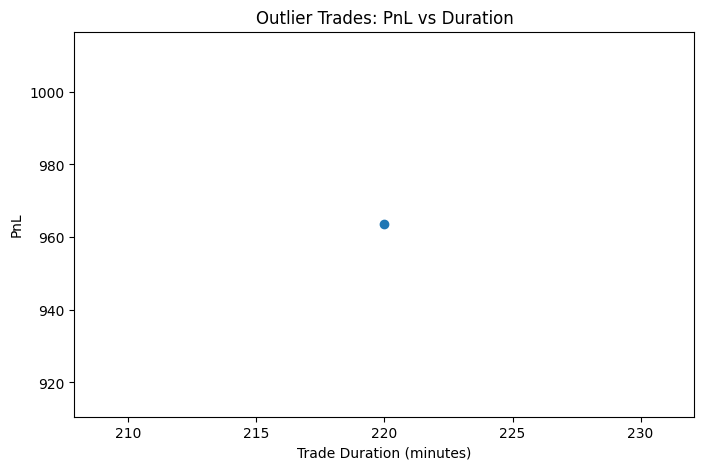

In [9]:
plt.figure(figsize=(8,5))
plt.scatter(outliers['duration_min'], outliers['pnl'])
plt.xlabel("Trade Duration (minutes)")
plt.ylabel("PnL")
plt.title("Outlier Trades: PnL vs Duration")
plt.savefig("../plots/pnl_vs_duration.png")
plt.show()


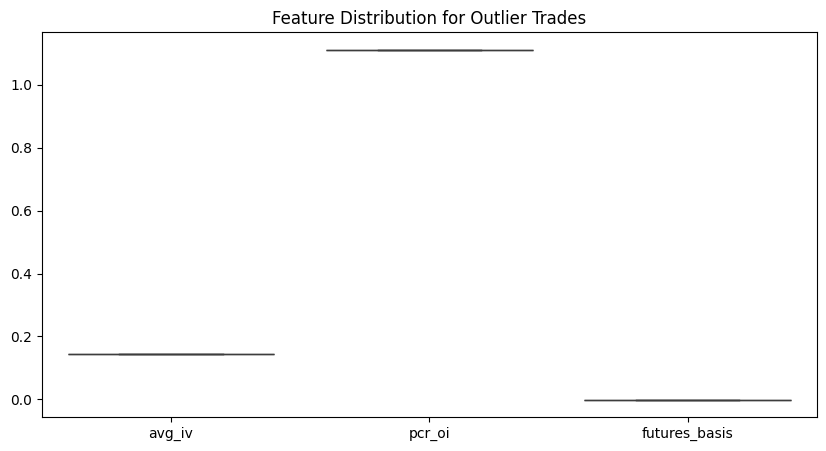

In [10]:
features = ['avg_iv','pcr_oi','futures_basis']

plt.figure(figsize=(10,5))
sns.boxplot(data=outliers[features])
plt.title("Feature Distribution for Outlier Trades")
plt.savefig("../plots/outlier_boxplot.png")
plt.show()


c:\Users\virat\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\virat\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


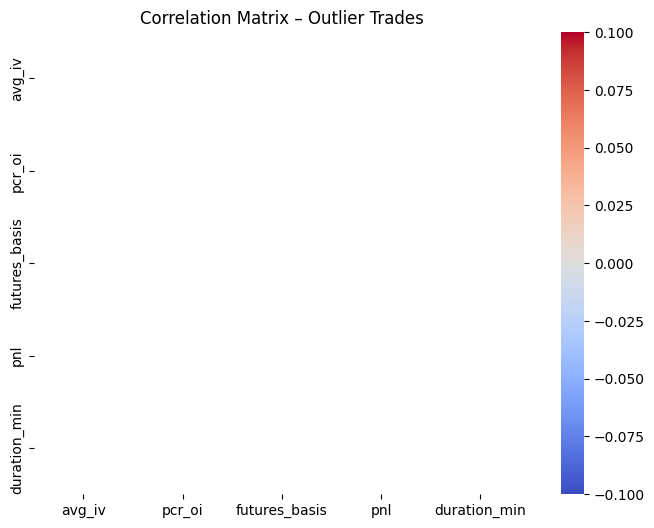

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(
    outliers[features + ['pnl','duration_min']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title("Correlation Matrix – Outlier Trades")
plt.savefig("../plots/feature_correlation.png")
plt.show()


In [21]:
with open("../results/outlier_insights.txt", "w") as f:
    f.write(f"Total Trades: {len(trades)}\n")
    f.write(f"Outlier Trades (>3 std dev): {len(outliers)} ({outlier_pct:.2f}%)\n\n")
    f.write(f"Average Outlier PnL: {avg_outlier_pnl:.2f}\n")
    f.write(f"Average Normal PnL: {avg_normal_pnl:.2f}\n\n")
    f.write("Regime Distribution of Outliers:\n")
    f.write(str(outliers['regime'].value_counts(normalize=True) * 100))
